In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

In [5]:
df = pd.read_csv('df_scaled.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   povertyPercentage          166664 non-null  float64
 1   incident_gravity           166664 non-null  float64
 2   females_rate               166664 non-null  float64
 3   minor_rate                 166664 non-null  float64
 4   arrested_rate              166664 non-null  float64
 5   survival_rate              166664 non-null  float64
 6   winning_party_percentage   166664 non-null  float64
 7   killed_rate                166664 non-null  float64
 8   injured_rate               166664 non-null  float64
 9   killed_disp_per_district   166664 non-null  float64
 10  injured_disp_per_district  166664 non-null  float64
 11  part_disp_per_district     166664 non-null  float64
 12  avg_age_participants       166664 non-null  float64
 13  n_participants             16

In [6]:
df['state'].value_counts().head(3)

state
illinois      14276
california    11975
florida        9713
Name: count, dtype: int64

We selected one state as stated in subtask of clustering task.

In particular, we decided to select the state with the second higher number of gun incidents which resulted California

In [7]:
df = df.loc[df['state'] == 'california']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11975 entries, 7720 to 166507
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   povertyPercentage          11975 non-null  float64
 1   incident_gravity           11975 non-null  float64
 2   females_rate               11975 non-null  float64
 3   minor_rate                 11975 non-null  float64
 4   arrested_rate              11975 non-null  float64
 5   survival_rate              11975 non-null  float64
 6   winning_party_percentage   11975 non-null  float64
 7   killed_rate                11975 non-null  float64
 8   injured_rate               11975 non-null  float64
 9   killed_disp_per_district   11975 non-null  float64
 10  injured_disp_per_district  11975 non-null  float64
 11  part_disp_per_district     11975 non-null  float64
 12  avg_age_participants       11975 non-null  float64
 13  n_participants             11975 non-null  floa

In [8]:
column_to_drop = ['avg_age_participants','n_participants','n_participants_child', 'n_participants_teen', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'isKilled', 'involve_injury','pc1', 'pc2']

       
for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)
column_to_drop

['avg_age_participants',
 'n_participants',
 'n_participants_child',
 'n_participants_teen',
 'n_females',
 'n_killed',
 'n_injured',
 'n_arrested',
 'n_unharmed',
 'date',
 'latitude',
 'longitude',
 'congressional_district',
 'candidatevotes',
 'totalvotes',
 'isKilled',
 'involve_injury',
 'pc1',
 'pc2',
 'date',
 'state',
 'city_or_county',
 'incident_characteristics1',
 'party']

In [9]:
df_categorical = df[column_to_drop].copy()
df_numeric = df.drop(columns=column_to_drop)

In [10]:
df_categorical.info()
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11975 entries, 7720 to 166507
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   avg_age_participants       11975 non-null  float64
 1   n_participants             11975 non-null  float64
 2   n_participants_child       11975 non-null  int64  
 3   n_participants_teen        11975 non-null  int64  
 4   n_females                  11975 non-null  float64
 5   n_killed                   11975 non-null  float64
 6   n_injured                  11975 non-null  float64
 7   n_arrested                 11975 non-null  float64
 8   n_unharmed                 11975 non-null  float64
 9   date                       11975 non-null  object 
 10  latitude                   11975 non-null  float64
 11  longitude                  11975 non-null  float64
 12  congressional_district     11975 non-null  int64  
 13  candidatevotes             11975 non-null  int6

# Hierarchical clustering (Agglomerative)

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
from sklearn import metrics

## Grid

In [ ]:
table = []
for metric in ['cityblock','correlation', 'cosine', 'euclidean']:
    methods = ['complete','single','average','weighted']
    if metric == 'euclidean':
        methods += ['ward','median','centroid']
    for method in methods:
        for truncation_mode in [None, 'lastp','level']:
            for level in [2,5,15]:
                for k in [5, 10]:
                    distances = pdist(df_numeric, metric=metric)
                    dlinkage = linkage(distances, metric=metric, method=method)
                    labels = fcluster(dlinkage,k,criterion='maxclust')
                    current_silhouette = silhouette_score(df_numeric, labels)
                    current_bouldin = metrics.davies_bouldin_score(df_numeric, labels)
                    print(f"metric: {metric}, method:{method}, truncation_mode:{truncation_mode}, level':{level}, k:{k}, silhouette: {current_silhouette} , DBscore:{current_bouldin}")
                    dendrogram(dlinkage, truncate_mode=truncation_mode, p=level, leaf_rotation=90)
                    plt.show()
                    table.append({'metric':metric, 'method':method, 'truncation_mode': truncation_mode, 'level':level, 'k':k, 'silhouette': current_silhouette, 'DBscore':current_bouldin})

df_table = pd.DataFrame(table)

## Best hyperparameter from the grid

Retraining the best Hierachical clustering found    

metric: euclidean, method:ward, truncation_mode:lastp, level':10, k:5, silhouette: 0.3063902973437957 , DBscore:1.2911929898379735


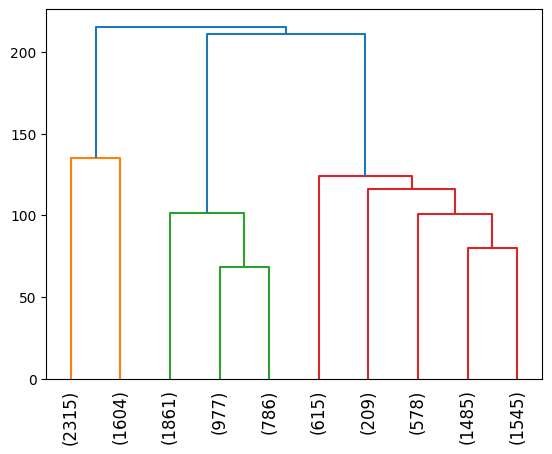

In [12]:
table = []
metric = "euclidean"
method = "ward"
truncation_mode = "lastp"
level = 10
k = 5

distances = pdist(df_numeric, metric=metric)
dlinkage = linkage(distances, metric=metric, method=method)
clusters = fcluster(dlinkage,k,criterion='maxclust')
current_silhouette = silhouette_score(df_numeric, clusters)
current_bouldin = metrics.davies_bouldin_score(df_numeric, clusters)
print(f"metric: {metric}, method:{method}, truncation_mode:{truncation_mode}, level':{level}, k:{k}, silhouette: {current_silhouette} , DBscore:{current_bouldin}")
dendrogram(dlinkage, truncate_mode=truncation_mode, p=level, leaf_rotation=90)
plt.show()
table.append({'metric':metric, 'method':method, 'truncation_mode': truncation_mode, 'level':level, 'k':k, 'silhouette': current_silhouette, 'DBscore':current_bouldin})


Final Model

In [13]:
n_clusters = len(np.unique(clusters))
# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(1, n_clusters + 1):
    occ_list.append(np.count_nonzero(np.array(clusters) == k))

print('cluster sizes:', occ_list)

cluster sizes: [2315, 1604, 3624, 615, 3817]


PCA

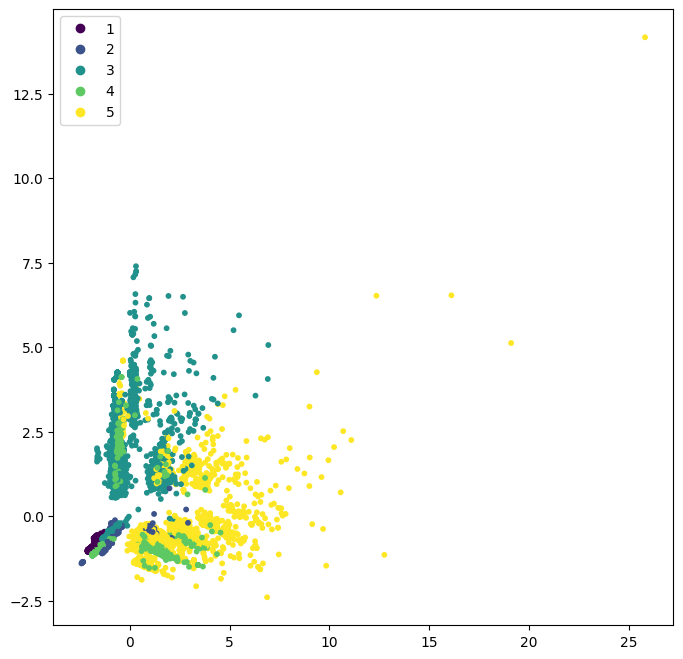

In [104]:
plt.figure(figsize=(8,8))

scatter = plt.scatter(df['pc1'], df['pc2'], c=np.array(clusters), s=10)

plt.tick_params(axis='both', which='major')
plt.legend(*scatter.legend_elements())

Plot of cluster labels distribution

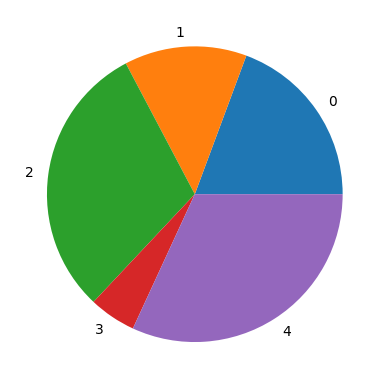

In [92]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show()

Radar plot

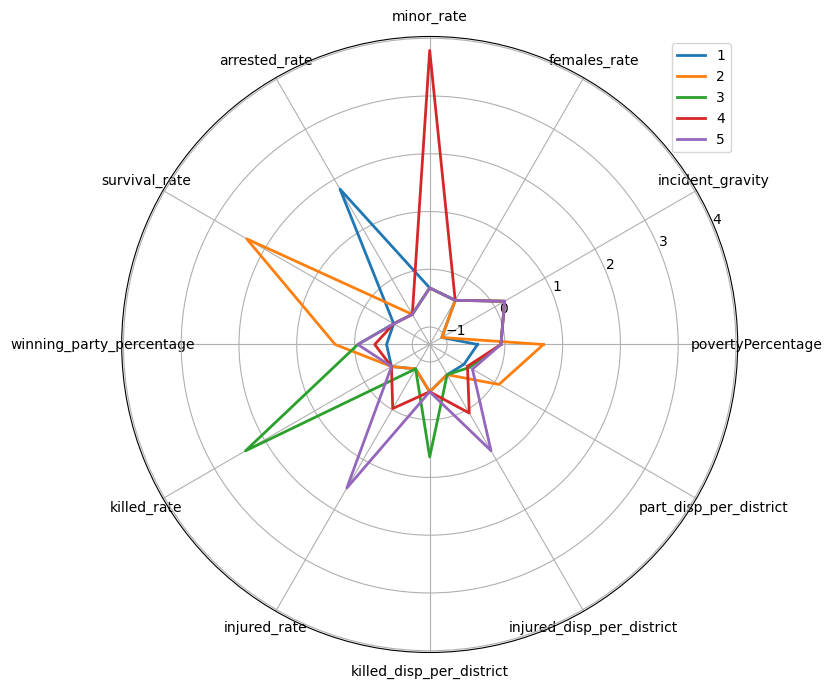

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import math

N = len(df_numeric.columns)
plt.figure(figsize=(8, 8))



for k in range(1, n_clusters + 1):
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
     
    values = df_numeric[np.array(clusters) == k].median().values.tolist()
    
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)
    plt.xticks(angles[:-1], df_numeric.columns)
    ax.plot(angles, values, linewidth=2)


plt.legend(labels=np.unique(np.array(clusters)))

plt.show()


Line plot

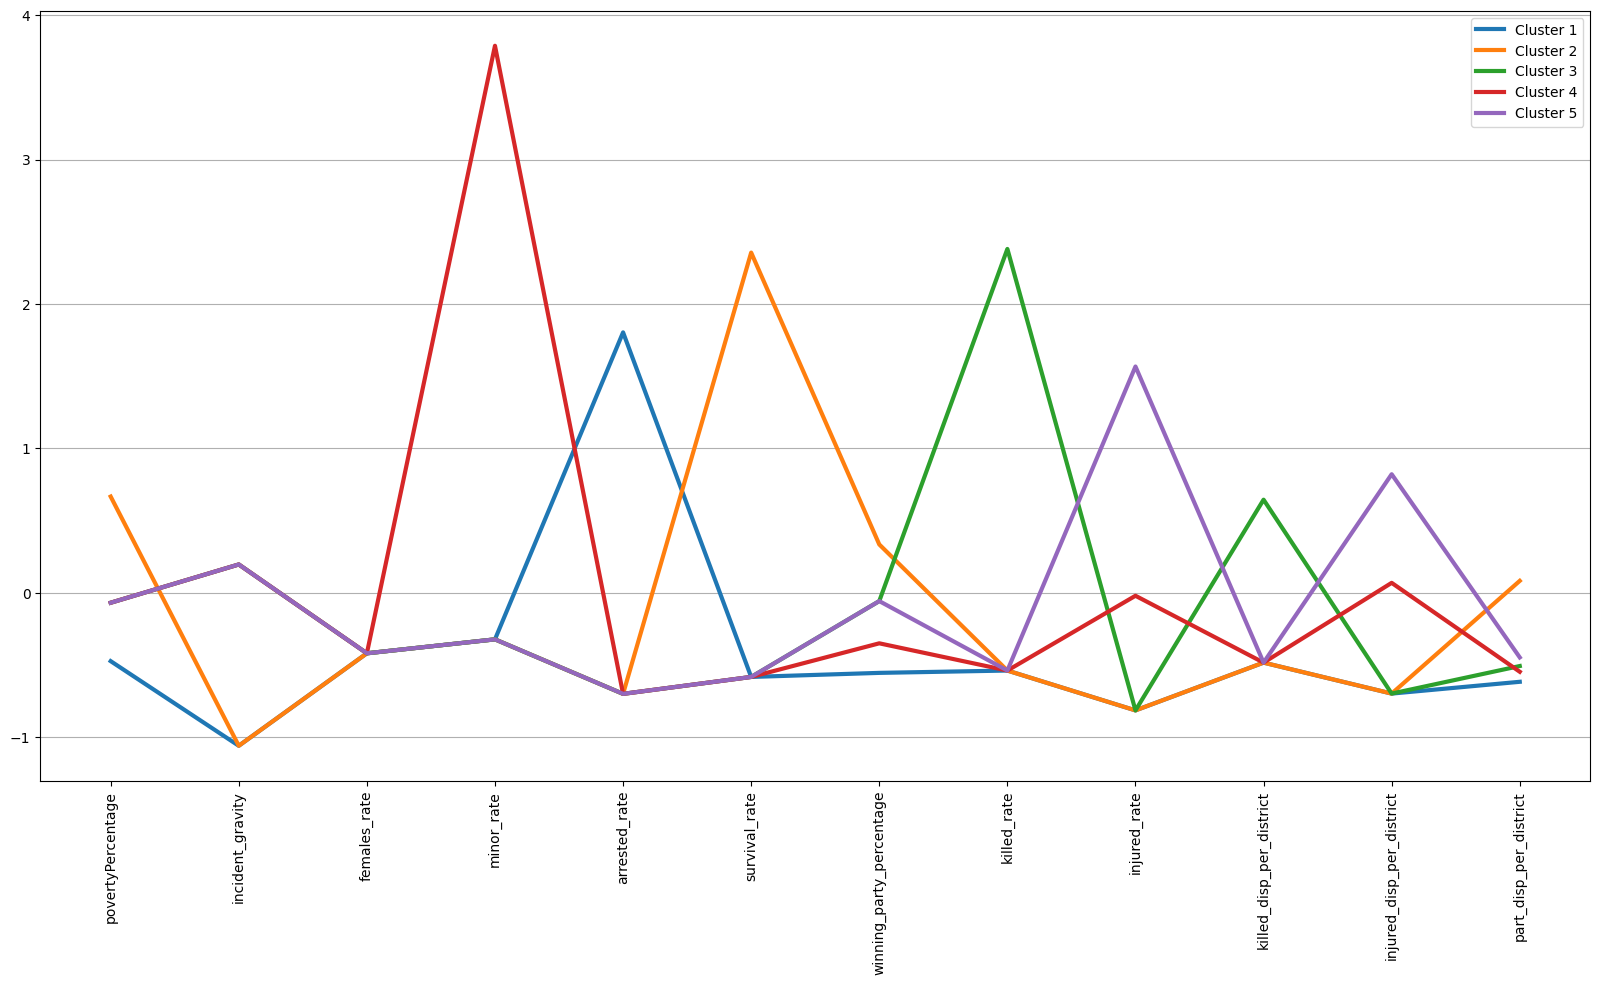

In [95]:
plt.figure(figsize=(20, 10))

for label in np.unique(np.array(clusters)):
    cent = df_numeric[np.array(clusters) == label].median()
    plt.plot(cent, label="Cluster %s" % label, linewidth=3)
plt.tick_params(axis='both', which='major')
plt.xticks(range(0, len(df_numeric.columns)), df_numeric.columns, rotation=90)
plt.legend()
plt.gca().yaxis.grid(True)

plt.show()

We can see that each cluster is identified by a different feature.

## Characterizing clusters with cities

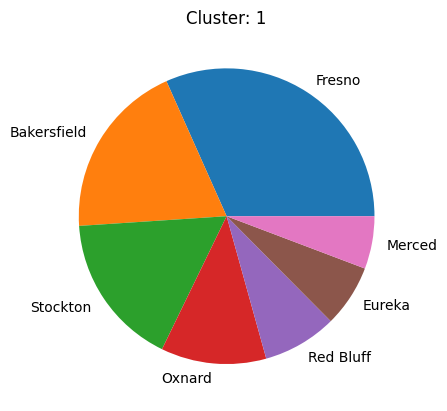

city_or_county
Fresno         242
Bakersfield    148
Stockton       128
Oxnard          88
Red Bluff       62
Eureka          52
Merced          44
Name: count, dtype: int64


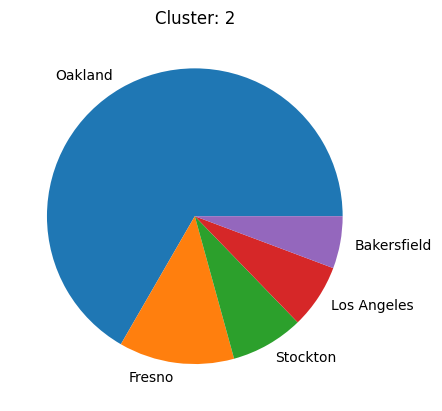

city_or_county
Oakland        502
Fresno          95
Stockton        60
Los Angeles     53
Bakersfield     43
Name: count, dtype: int64


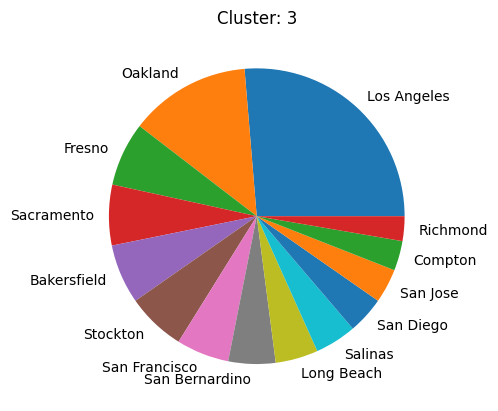

city_or_county
Los Angeles       429
Oakland           216
Fresno            114
Sacramento        108
Bakersfield       106
Stockton          105
San Francisco      94
San Bernardino     84
Long Beach         76
Salinas            74
San Diego          66
San Jose           61
Compton            53
Richmond           44
Name: count, dtype: int64


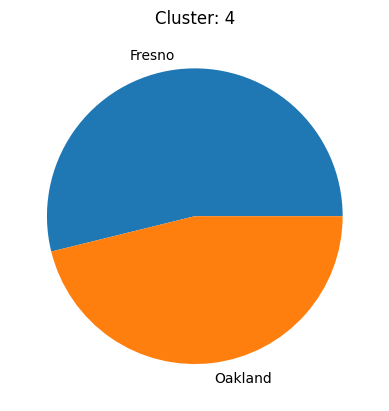

city_or_county
Fresno     49
Oakland    42
Name: count, dtype: int64


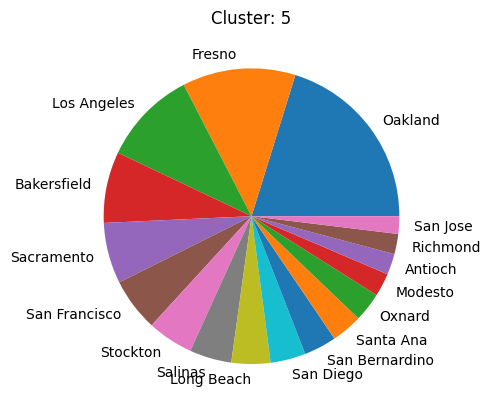

city_or_county
Oakland           431
Fresno            264
Los Angeles       221
Bakersfield       166
Sacramento        142
San Francisco     124
Stockton          107
Salinas            98
Long Beach         91
San Diego          82
San Bernardino     76
Santa Ana          72
Oxnard             68
Modesto            54
Antioch            49
Richmond           47
San Jose           41
Name: count, dtype: int64


In [96]:
for k in range(1, n_clusters + 1):
    injury_for_clust = df_categorical['city_or_county'].loc[ np.array(clusters) == k].value_counts() 
    injury_for_clust = injury_for_clust[injury_for_clust > 40]
    # Show pie plot
    plt.title('Cluster: ' + str(k))
    plt.pie(injury_for_clust, labels= injury_for_clust.index)
    plt.show()
    print(injury_for_clust)

There are variations in city compositions across the clusters: three clusters exhibit a more balanced distribution of cities, each with a predominant main city; another cluster predominantly is composed by two cities, while one is primarily composed of a single main city, making up almost 70% of its composition.

##  Characterizing clusters with incident char

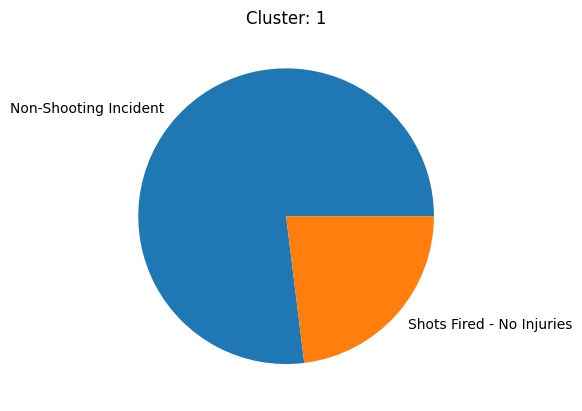

incident_characteristics1
Non-Shooting Incident        1737
Shots Fired - No Injuries     520
Name: count, dtype: int64


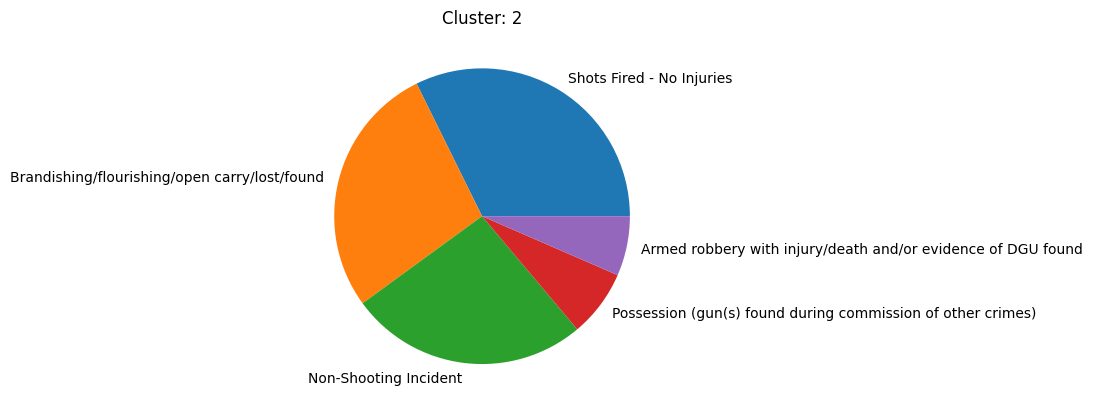

incident_characteristics1
Shots Fired - No Injuries                                       396
Brandishing/flourishing/open carry/lost/found                   340
Non-Shooting Incident                                           320
Possession (gun(s) found during commission of other crimes)      90
Armed robbery with injury/death and/or evidence of DGU found     80
Name: count, dtype: int64


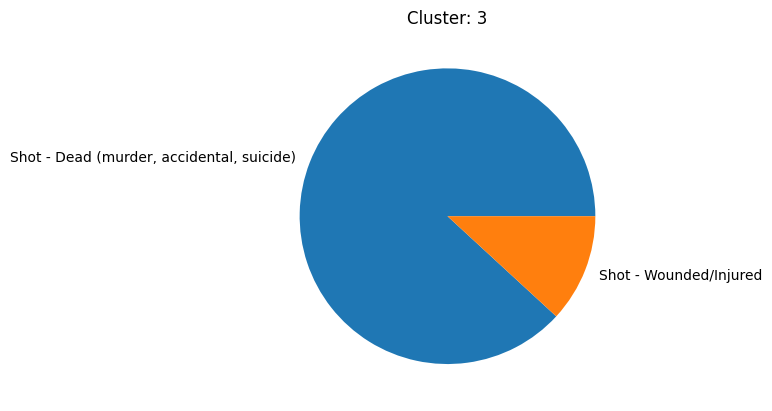

incident_characteristics1
Shot - Dead (murder, accidental, suicide)    3118
Shot - Wounded/Injured                        419
Name: count, dtype: int64


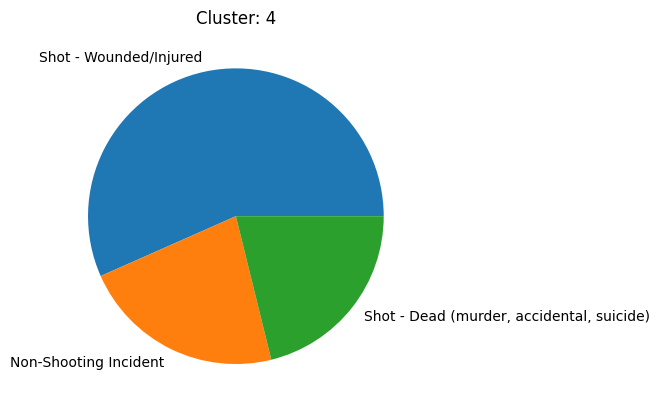

incident_characteristics1
Shot - Wounded/Injured                       316
Non-Shooting Incident                        124
Shot - Dead (murder, accidental, suicide)    118
Name: count, dtype: int64


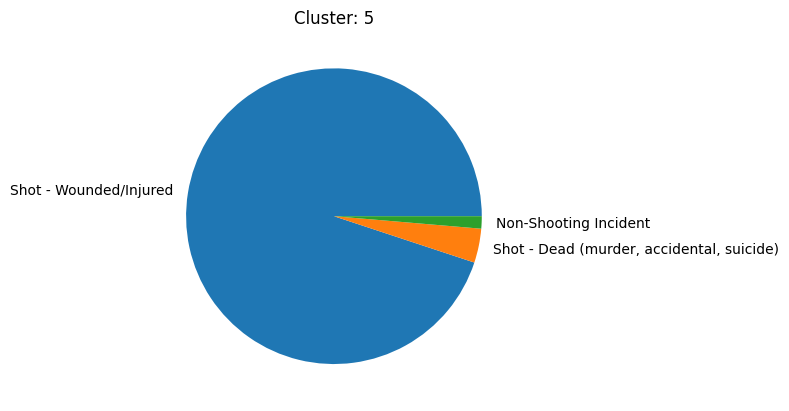

incident_characteristics1
Shot - Wounded/Injured                       3591
Shot - Dead (murder, accidental, suicide)     141
Non-Shooting Incident                          51
Name: count, dtype: int64


In [97]:
for k in range(1, n_clusters + 1):
    incident_char_clust = df_categorical['incident_characteristics1'].loc[np.array(clusters) == k].value_counts() 
    incident_char_clust = incident_char_clust[incident_char_clust > 50]
    # Show pie plot
    plt.title('Cluster: ' + str(k))
    plt.pie(incident_char_clust, labels= incident_char_clust.index)
    plt.show()
    print(incident_char_clust)

## Characterizing clusters with arrested, unharmed, killing, injuried

In [2]:
df_task_1 = pd.read_csv('../DM_6_TASK1/df_after_dp.csv')

In [99]:
df_task_1 = df_task_1[df_task_1['state'] == 'california']

df_categorical.loc[df_task_1['n_arrested'] > 0, 'involve_arrest'] = 1
df_categorical.loc[df_task_1['n_arrested'] == 0, 'involve_arrest'] = 0

df_categorical.loc[df_task_1['n_unharmed'] > 0, 'involve_unharmed'] = 1
df_categorical.loc[df_task_1['n_unharmed'] == 0, 'involve_unharmed'] = 0

In [100]:
color_map = {0: 'royalblue', 1: 'darkslategrey'}

def get_colors(data):
    return [color_map[val] for val in data.index]

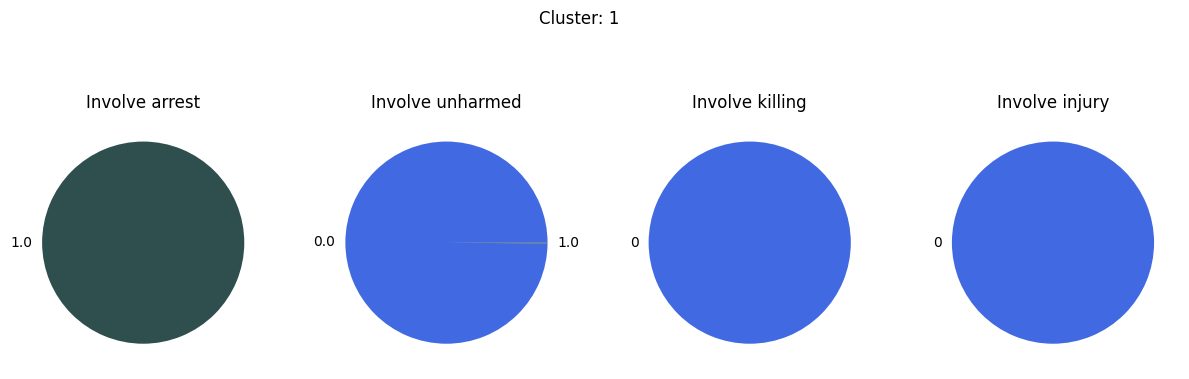

involve_arrest
1.0    2315
Name: count, dtype: int64

involve_unharmed
0.0    2312
1.0       3
Name: count, dtype: int64

isKilled
0    2315
Name: count, dtype: int64

involve_injury
0    2315
Name: count, dtype: int64


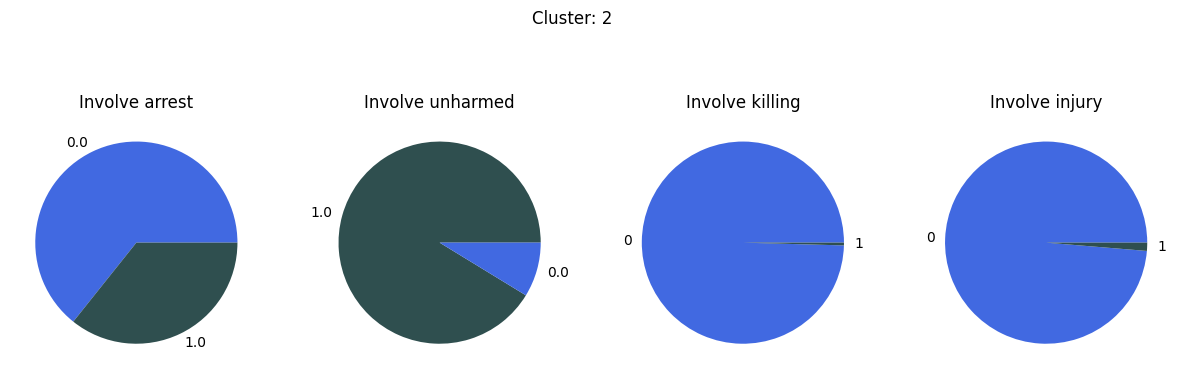

involve_arrest
0.0    1031
1.0     573
Name: count, dtype: int64

involve_unharmed
1.0    1464
0.0     140
Name: count, dtype: int64

isKilled
0    1597
1       7
Name: count, dtype: int64

involve_injury
0    1583
1      21
Name: count, dtype: int64


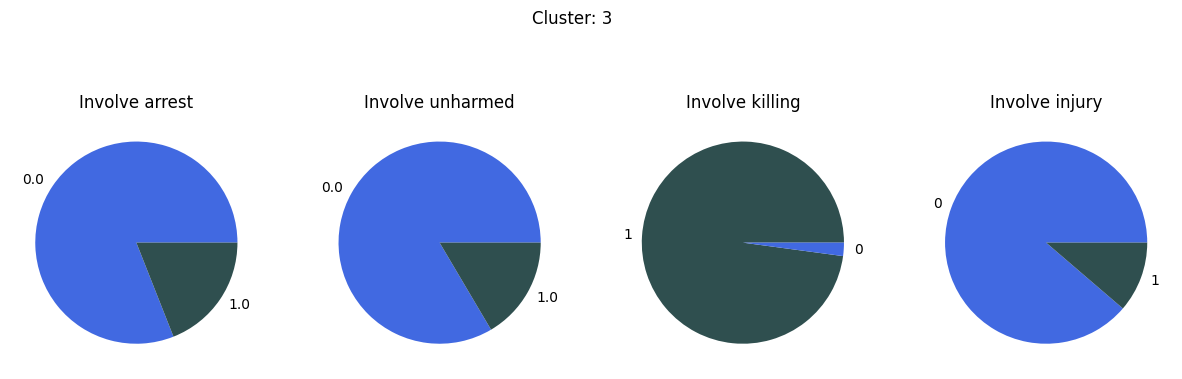

involve_arrest
0.0    2935
1.0     689
Name: count, dtype: int64

involve_unharmed
0.0    3026
1.0     598
Name: count, dtype: int64

isKilled
1    3547
0      77
Name: count, dtype: int64

involve_injury
0    3215
1     409
Name: count, dtype: int64


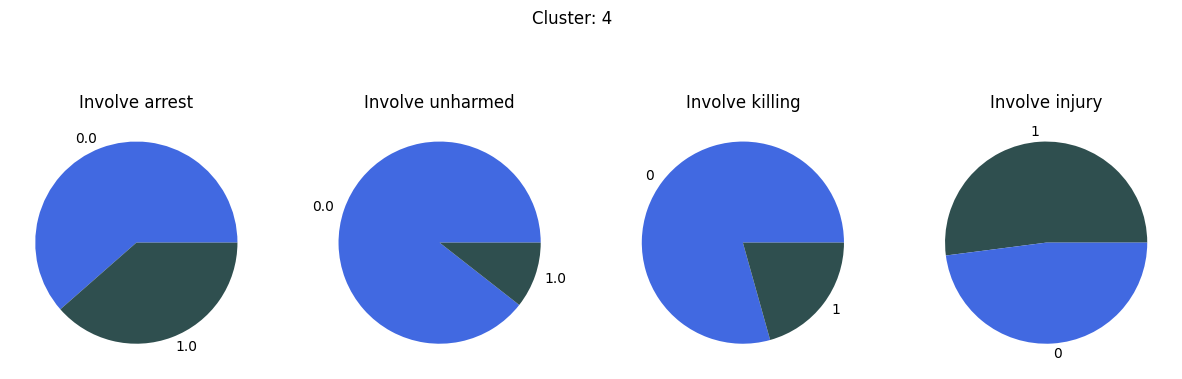

involve_arrest
0.0    378
1.0    237
Name: count, dtype: int64

involve_unharmed
0.0    550
1.0     65
Name: count, dtype: int64

isKilled
0    488
1    127
Name: count, dtype: int64

involve_injury
1    320
0    295
Name: count, dtype: int64


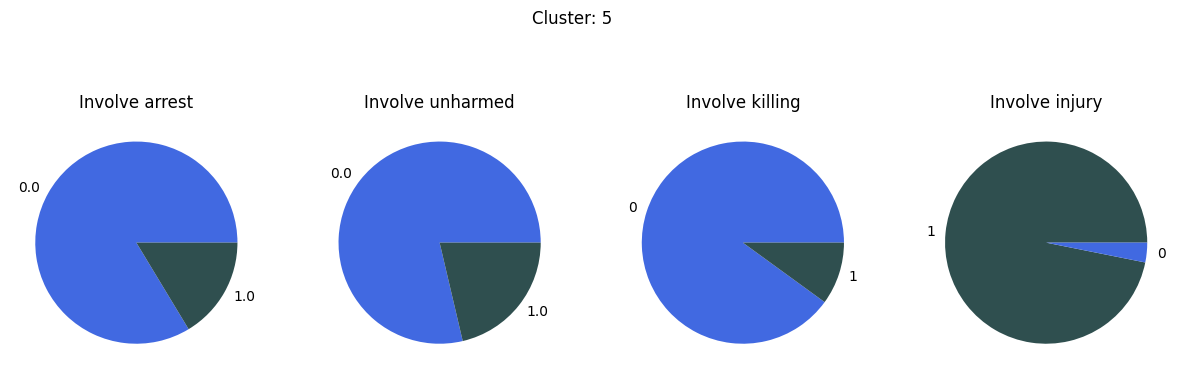

involve_arrest
0.0    3193
1.0     624
Name: count, dtype: int64

involve_unharmed
0.0    3003
1.0     814
Name: count, dtype: int64

isKilled
0    3435
1     382
Name: count, dtype: int64

involve_injury
1    3697
0     120
Name: count, dtype: int64


In [103]:

for k in range(1, n_clusters + 1):
    
    n_arrested_clust =  df_categorical["involve_arrest"].loc[np.array(clusters) == k].value_counts()
    n_unharmed_clust = df_categorical['involve_unharmed'].loc[np.array(clusters) == k].value_counts() 
    n_killed_clust = df_categorical['isKilled'].loc[np.array(clusters) == k].value_counts()
    n_injured_clust = df_categorical['involve_injury'].loc[np.array(clusters) == k].value_counts()

    #showing the two pie plots together
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.suptitle('Cluster: ' + str(k))
    fig.set_figwidth(15)
    ax1.pie(n_arrested_clust, labels= n_arrested_clust.index, colors=get_colors(n_arrested_clust))
    ax2.pie(n_unharmed_clust, labels= n_unharmed_clust.index, colors=get_colors(n_unharmed_clust))
    ax3.pie(n_killed_clust, labels= n_killed_clust.index, colors=get_colors(n_killed_clust))
    ax4.pie(n_injured_clust, labels= n_injured_clust.index, colors=get_colors(n_injured_clust))

    #adding ax1 and ax2 titles
    ax1.set_title('Involve arrest')
    ax2.set_title('Involve unharmed')
    ax3.set_title('Involve killing')
    ax4.set_title('Involve injury')

    #change the colors of the pie plots
    

    plt.show()

    print(n_arrested_clust)
    print()
    print(n_unharmed_clust)
    print()
    print(n_killed_clust)
    print()
    print(n_injured_clust)


The clusters exhibit five distinct structures based on the type of incidents they represent:
1) The first cluster predominantly involves arrests and comprises minor crimes without injuries or fatalities, often lacking the use of firearms or shootings resulting in no injuries.
2) The second cluster consists of relatively peaceful incidents, mostly ending with no injuries and often leading to the arrest of the suspects.
3) The third cluster is characterized by fatal incidents.
4) The fourth cluster contains a mixture of incident types.
5) The fifth cluster involves shooting incidents, resulting in injuries in almost all cases.